<a href="https://colab.research.google.com/github/HuaiyuZhang/DeepLearning/blob/main/OpenMMLab-Camp/Assignment_1_MMDetection_MMPose/%5BMMDetection%2BMMPose%5DTriangle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detect triangle and estimate key points
First use MMDetection to locate the triangle, then use MMPose to detect the key points.

# 0. Environment setup

## 0.1 MMPose installation and download data

In [69]:
!pwd

/content/mmpose


In [ ]:
!pip3 install install torch==1.12.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip3 install install torchvision==0.13.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip3 install install torchaudio==0.12.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
!pip install -U openmim
!mim install mmengine
!mim install 'mmcv==2.0.0rc3'
!mim install "mmdet>=3.0.0rc6"
!pip install opencv-python pillow matplotlib seaborn tqdm pycocotools -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
# Clone the mmpose repo
!git clone https://github.com/open-mmlab/mmpose.git -b tutorial2023

In [8]:
import os
os.chdir('mmpose')

In [ ]:
# install MMPose
!mim install -e .

In [49]:
import os

# Create checkpoint directory to save pre-trained weights
os.mkdir('checkpoint')

# Create outputs to save prediction results
os.mkdir('outputs')

# Create data directory to save images and videos
os.mkdir('data')

os.mkdir('data/test')

In [ ]:
# Multiple persons, source: https://www.pexels.com/zh-cn/photo/2168292/
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220610-mmpose/images/multi-person.jpeg -O data/test/multi-person.jpeg

# Single person video
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/videos/cxk.mp4 -P data/test

# Two persons video
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/videos/mother_wx.mp4 -P data/test

# Two girls dancing video, source：https://mixkit.co/free-stock-video/two-girls-having-fun-in-a-retro-restaurant-42298/
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220610-mmpose/videos/two-girls.mp4 -O data/test/two-girls.mp4

In [66]:
import torch, torchvision
print('Pytorch version', torch.__version__)
print('CUDA availability',torch.cuda.is_available())

Pytorch version 1.12.1+cu113
CUDA availability True


In [67]:
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print('MMCV version', mmcv.__version__)
print('CUDA version', get_compiling_cuda_version())
print('compiler version', get_compiler_version())

MMCV version 2.0.0
CUDA version 11.3
compiler version GCC 9.3


In [68]:
import mmpose
print('mmpose version', mmpose.__version__)

mmpose version 1.0.0


## 0.2 MMDetection installation and download data

In [16]:
!pwd

/content/mmpose


In [17]:
os.chdir('/content')

In [19]:
!git clone https://github.com/open-mmlab/mmdetection.git -b 3.x

Cloning into 'mmdetection'...
remote: Enumerating objects: 36296, done.
remote: Counting objects: 100% (947/947), done.
remote: Compressing objects: 100% (488/488), done.
remote: Total 36296 (delta 487), reused 771 (delta 446), pack-reused 35349
Receiving objects: 100% (36296/36296), 56.79 MiB | 18.53 MiB/s, done.
Resolving deltas: 100% (25420/25420), done.


In [20]:
os.chdir('mmdetection')

In [ ]:
!pip install -v -e .

In [22]:
import os

# Create checkpoint directory to save pre-trained weights
os.mkdir('checkpoint')

# Create outputs to save prediction results
os.mkdir('outputs')

# Create data directory to save images and videos
os.mkdir('data')
os.mkdir('data/test')

In [70]:
# Check mmdetection
import mmdet
print('mmdetection version', mmdet.__version__)

mmdetection version 3.0.0


# 0.3 Test prediction using MMPose

In [24]:
import os
os.chdir('/content/mmpose')

In [25]:
os.listdir('/content/mmpose/data/test/')

['mother_wx.mp4', 'two-girls.mp4', 'cxk.mp4', 'multi-person.jpeg']

# 0.3.1 Model zoo
###  Object detection models
MMDetection ：https://github.com/open-mmlab/mmdetection/blob/master/docs/en/model_zoo.md

demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py

https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

### MMPose Human Pose Estimation Model
configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py

https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth

### RTMPose Human Pose Estimation Model
RTMPose：https://github.com/open-mmlab/mmpose/tree/dev-1.x/projects/rtmpose

RTMPose-S

projects/rtmpose/rtmpose/body_2d_keypoint/rtmpose-s_8xb256-420e_coco-256x192.py

https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmpose-s_simcc-aic-coco_pt-aic-coco_420e-256x192-fcb2599b_20230126.pth

RTMPose-L

projects/rtmpose/rtmpose/body_2d_keypoint/rtmpose-l_8xb256-420e_coco-384x288.py

https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmpose-l_simcc-aic-coco_pt-aic-coco_420e-384x288-97d6cb0f_20230228.pth

# 0.3.2 Predict a single image

In [7]:
import os

In [8]:
os.chdir('/content/mmpose/')

In [72]:
# Had RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem .
# Update numpy to resolve the problem
# !pip3 install numpy --upgrade

In [10]:
!python demo/topdown_demo_with_mmdet.py \
        demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py \
        https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth \
        configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py \
        https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth \
        --input data/test/multi-person.jpeg \
        --output-root outputs/B1_HRNet_1 \
        --device cuda:0 \
        --bbox-thr 0.5 \
        --kpt-thr 0.2 \
        --nms-thr 0.3 \
        --radius 8 \
        --thickness 4 \
        --draw-bbox \
        --draw-heatmap \
        --show-kpt-idx

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Downloading: "https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth" to /root/.cache/torch/hub/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
100% 160M/160M [00:02<00:00, 65.2MB/s]
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth
Downloading: "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w32_coco_256x192-c78dce93_20200708.pth
100% 109M/109M [00:02<00:00, 40.3MB/s]
06/04 10:24:10 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


Find the result in `outputs/B1_HRNet_1`

# 1. Triangle detection
# 1.1 Download data for both directories: mmpose and mmdetection

In [50]:
import os
os.chdir('/content/mmpose')
# os.chdir('/content/mmdetection') # run data downloading in both directories 

In [ ]:
!rm -rf data/Triangle_215_Keypoint_coco data/Triangle_215_Keypoint_coco.zip
!wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/Triangle_215_Keypoint_coco.zip -P data

In [ ]:
!unzip data/Triangle_215_Keypoint_coco.zip -d data >> /dev/null # Unzip
!rm -rf data/Triangle_215_Keypoint_coco.zip # delete raw zip file
!mkdir data/test_triangle
# Images of triangle rulers，by 同济子豪兄、田文博
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/test_img/triangle_1.jpg -P data/test_triangle
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/test_img/triangle_2.jpg -P data/test_triangle
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/test_img/triangle_3.jpg -P data/test_triangle
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/test_img/triangle_4.jpg -P data/test_triangle

# Videos of triangle rulers, by 同济子豪兄，田文博
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/videos/triangle_6.mp4 -P data/test_triangle
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/videos/triangle_7.mp4 -P data/test_triangle
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/videos/triangle_9.mp4 -P data/test_triangle

In [54]:
# See the images
# from PIL import Image
# Image.open('data/Triangle_215_Keypoint_coco/images/DSC_0373.jpg')

In [56]:
!find . -iname '__MACOSX'
!find . -iname '.DS_Store'
!find . -iname '.ipynb_checkpoints'

!for i in `find . -iname '__MACOSX'`; do rm -rf $i;done
!for i in `find . -iname '.DS_Store'`; do rm -rf $i;done
!for i in `find . -iname '.ipynb_checkpoints'`; do rm -rf $i;done

!find . -iname '__MACOSX'
!find . -iname '.DS_Store'
!find . -iname '.ipynb_checkpoints'


# Download Config file

In [22]:
import os
# os.chdir('/content/mmpose')
os.chdir('/content/mmdetection')
# Faster R CNN 三角板目标检测
!rm -rf data/faster_r_cnn_triangle.py
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/faster_r_cnn_triangle.py -P data
# RTMDet-Tiny 三角板目标检测
!rm -rf data/rtmdet_tiny_triangle.py
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/rtmdet_tiny_triangle.py -P data

--2023-06-04 10:35:34--  https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/faster_r_cnn_triangle.py
Resolving zihao-openmmlab.obs.myhuaweicloud.com (zihao-openmmlab.obs.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.myhuaweicloud.com (zihao-openmmlab.obs.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8056 (7.9K) [binary/octet-stream]
Saving to: ‘data/faster_r_cnn_triangle.py’

faster_r_cnn_triang 100%[===================>]   7.87K  --.-KB/s    in 0.03s   

2023-06-04 10:35:35 (234 KB/s) - ‘data/faster_r_cnn_triangle.py’ saved [8056/8056]

--2023-06-04 10:35:35--  https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/rtmdet_tiny_triangle.py
Resolving zihao-openmmlab.obs.myhuaweicloud.com (zihao-openmmlab.obs.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.myhuaweicloud.com (zihao-openmmlab.obs.myhuaweicloud.com)|121.36.235.132|

# Train

In [25]:
import os
os.chdir('/content/mmdetection')
!python tools/train.py data/rtmdet_tiny_triangle.py

06/04 10:48:23 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 686347055
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code

In [26]:
# Eval on testing set
!python tools/test.py data/rtmdet_tiny_triangle.py work_dirs/rtmdet_tiny_triangle/epoch_20.pth

06/04 11:05:05 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 211276892
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code

# Prediction

In [42]:
import os
os.chdir('/content/mmdetection')
# Single image RTMDet
!python demo/image_demo.py \
        data/test_triangle/triangle_3.jpg \
        data/rtmdet_tiny_triangle.py \
        --weights /content/mmdetection/work_dirs/rtmdet_tiny_triangle/epoch_20.pth \
        --out-dir outputs/E2_rtmdet \
        --device cuda:0 \
        --pred-score-thr 0.3

Loads checkpoint by local backend from path: /content/mmdetection/work_dirs/rtmdet_tiny_triangle/epoch_20.pth
06/04 11:19:22 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
06/04 11:19:22 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: 
torch.meshgrid: in an upcoming release, it will be required to pass the indexing
argument. (Triggered internally at  
../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:757
: UserWarning: Warning: The b

In [46]:
# Video RTMDet
!python demo/video_demo.py \
        data/test_triangle/triangle_9.mp4 \
        data/rtmdet_tiny_triangle.py \
        /content/mmdetection/work_dirs/rtmdet_tiny_triangle/epoch_20.pth \
        --device cuda:0 \
        --score-thr 0.4 \
        --out outputs/E2_out_video_rtmdet_self.mp4

Loads checkpoint by local backend from path: /content/mmdetection/work_dirs/rtmdet_tiny_triangle/epoch_20.pth
06/04 11:27:45 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
[                                                  ] 0/318, elapsed: 0s, ETA:/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[>>] 318/318, 4.5 task/s, elapsed: 71s, ETA:     0s


In [44]:
# RTMDet-Tiny pre-trained weight
!rm -rf checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220610-mmpose/triangle_dataset/ckpt/0512/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth -P checkpoint

--2023-06-04 11:25:23--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220610-mmpose/triangle_dataset/ckpt/0512/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19657604 (19M) [binary/octet-stream]
Saving to: ‘checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth’

rtmdet_tiny_triangl 100%[===================>]  18.75M  6.56MB/s    in 2.9s    

2023-06-04 11:25:27 (6.56 MB/s) - ‘checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth’ saved [19657604/19657604]



In [45]:
!python demo/video_demo.py \
        data/test_triangle/triangle_9.mp4 \
        data/rtmdet_tiny_triangle.py \
        /content/mmdetection/checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth \
        --device cuda:0 \
        --score-thr 0.6 \
        --out outputs/E2_out_video_rtmdet.mp4

Loads checkpoint by local backend from path: /content/mmdetection/checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth
06/04 11:26:01 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
[                                                  ] 0/318, elapsed: 0s, ETA:/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[  ] 142/318, 4.0 task/s, elapsed: 35s, ETA:    44s/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:757: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:828: UserWarning: Warning: The polygon is out of bounds, 

# Result Visualization

In [28]:
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

log_path = '/content/mmdetection/work_dirs/rtmdet_tiny_triangle/20230604_104822/vis_data/scalars.json'
with open(log_path, "r") as f:
    json_list = f.readlines()
print(len(json_list))
eval(json_list[4])

880


{'lr': 1.6055855855855853e-05,
 'data_time': 0.5574629306793213,
 'loss': 0.03607114255428314,
 'loss_cls': 0.032546627521514895,
 'loss_bbox': 0.003524515172466636,
 'time': 2.2955361366271974,
 'epoch': 1,
 'iter': 5,
 'memory': 1337,
 'step': 5}

In [ ]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for each in tqdm(json_list):
    if 'coco/bbox_mAP' in each:
        df_test = df_test.append(eval(each), ignore_index=True)
    else:
        df_train = df_train.append(eval(each), ignore_index=True)

In [30]:
df_train

,lr,data_time,loss,loss_cls,loss_bbox,time,epoch,iter,memory,step
0,4.000000e-08,2.745503,0.034004,0.032673,0.001331,9.699264,1.0,1.0,1279.0,1.0
1,4.043964e-06,1.378194,0.035493,0.032679,0.002813,5.023204,1.0,2.0,1337.0,2.0
2,8.047928e-06,0.922380,0.036058,0.032613,0.003446,3.489854,1.0,3.0,1337.0,3.0
3,1.205189e-05,0.694123,0.036155,0.032576,0.003578,2.767889,1.0,4.0,1337.0,4.0
4,1.605586e-05,0.557463,0.036071,0.032547,0.003525,2.295536,1.0,5.0,1337.0,5.0
...,...,...,...,...,...,...,...,...,...,...
855,3.423429e-03,0.272759,1.034874,0.462641,0.572233,0.718375,20.0,856.0,1337.0,856.0
856,3.427433e-03,0.252320,1.028322,0.458105,0.570217,0.697965,20.0,857.0,1337.0,857.0
857,3.431437e-03,0.260539,1.021910,0.454879,0.567031,0.701382,20.0,858.0,1337.0,858.0
858,3.435441e-03,0.260241,1.045012,0.473328,0.571684,0.696284,20.0,859.0,1337.0,859.0


In [31]:
df_test

,coco/bbox_mAP,coco/bbox_mAP_50,coco/bbox_mAP_75,coco/bbox_mAP_s,coco/bbox_mAP_m,coco/bbox_mAP_l,data_time,time,step
0,0.002,0.004,0.000,-1.0,-1.0,0.002,0.307911,0.371318,1.0
1,0.004,0.020,0.000,-1.0,-1.0,0.004,0.363035,0.446679,2.0
2,0.007,0.029,0.001,-1.0,-1.0,0.007,0.274308,0.343764,3.0
3,0.065,0.236,0.008,-1.0,-1.0,0.065,0.228444,0.287898,4.0
4,0.077,0.255,0.014,-1.0,-1.0,0.077,0.370532,0.451758,5.0
5,0.056,0.174,0.015,-1.0,-1.0,0.056,0.272803,0.340112,6.0
6,0.058,0.219,0.005,-1.0,-1.0,0.058,0.237483,0.292855,7.0
7,0.155,0.454,0.038,-1.0,-1.0,0.155,0.245694,0.290167,8.0
8,0.092,0.261,0.028,-1.0,-1.0,0.092,0.231957,0.284121,9.0
9,0.054,0.152,0.019,-1.0,-1.0,0.054,0.224518,0.279626,10.0


In [34]:
df_train.to_csv('/content/mmdetection/work_dirs/rtmdet_tiny_triangle/log_train.csv', index=False)
df_test.to_csv('/content/mmdetection/work_dirs/rtmdet_tiny_triangle/log_test.csv', index=False)

In [35]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

In [36]:
df_train.columns


Index(['lr', 'data_time', 'loss', 'loss_cls', 'loss_bbox', 'time', 'epoch',
       'iter', 'memory', 'step'],
      dtype='object')

In [37]:
metrics = ['loss', 'loss_bbox', 'loss_cls']

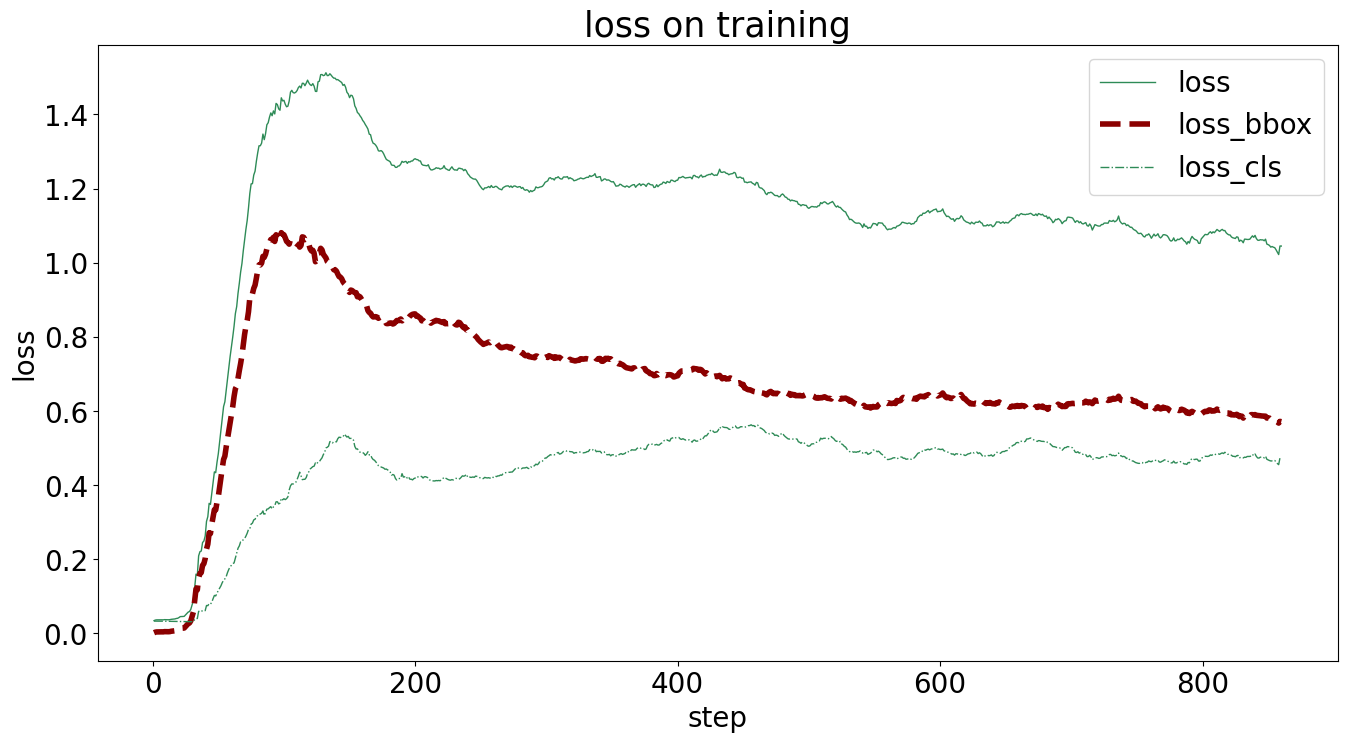

In [38]:
plt.figure(figsize=(16, 8))

x = df_train['step']
for y in metrics:
    plt.plot(x, df_train[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('loss on training', fontsize=25)
# plt.savefig('log_train.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

In [39]:
df_test.columns

Index(['coco/bbox_mAP', 'coco/bbox_mAP_50', 'coco/bbox_mAP_75',
       'coco/bbox_mAP_s', 'coco/bbox_mAP_m', 'coco/bbox_mAP_l', 'data_time',
       'time', 'step'],
      dtype='object')

In [40]:
metrics = ['coco/bbox_mAP', 'coco/bbox_mAP_50', 'coco/bbox_mAP_75', 'coco/bbox_mAP_s', 'coco/bbox_mAP_m', 'coco/bbox_mAP_l']


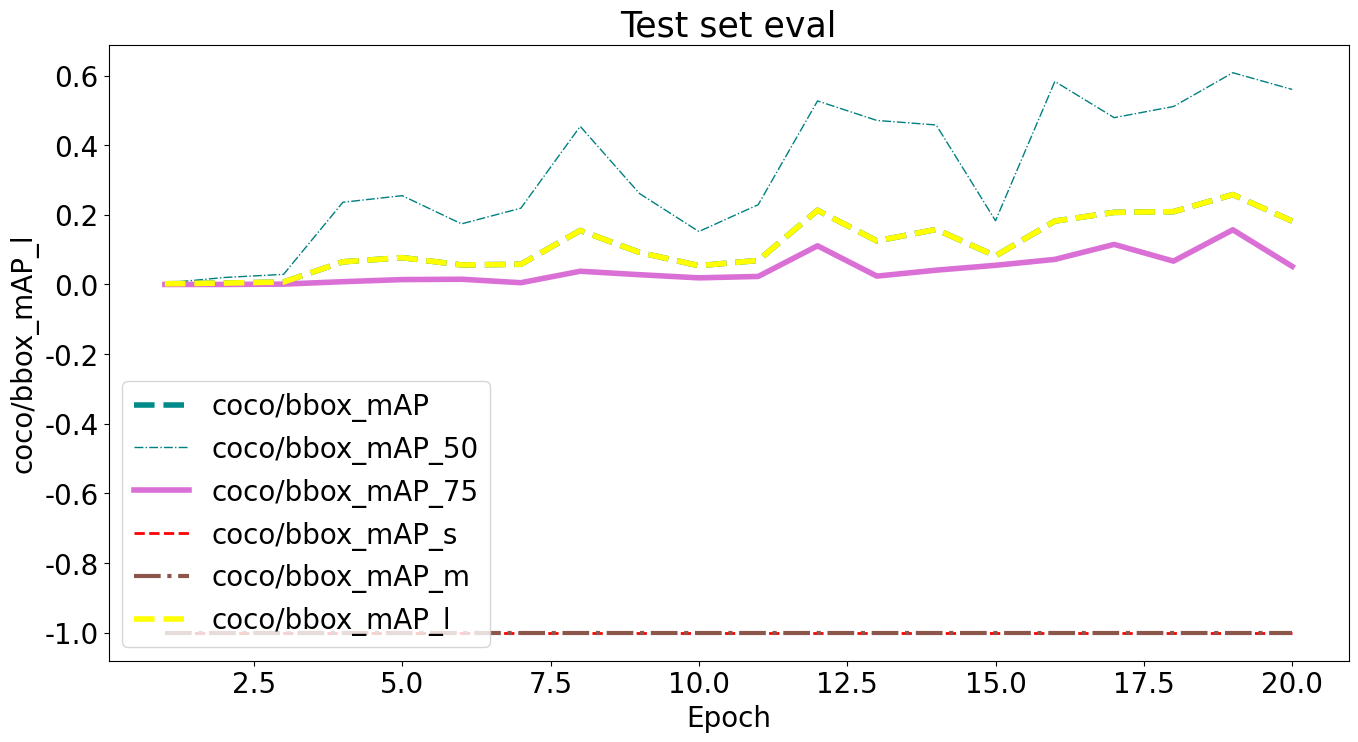

In [41]:
plt.figure(figsize=(16, 8))

x = df_test['step']
for y in metrics:
    plt.plot(x, df_test[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
# plt.ylim([0, 100])
plt.xlabel('Epoch', fontsize=20)
plt.ylabel(y, fontsize=20)
plt.title('Test set eval', fontsize=25)
# plt.savefig('测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

# RTMPose

In [58]:
import os
os.chdir('/content/mmpose')

In [59]:
!rm -rf data/rtmpose-s-triangle.py
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220610-mmpose/triangle_dataset/rtmpose-s-triangle.py -P data

--2023-06-04 11:39:59--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220610-mmpose/triangle_dataset/rtmpose-s-triangle.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13044 (13K) [binary/octet-stream]
Saving to: ‘data/rtmpose-s-triangle.py’

rtmpose-s-triangle. 100%[===================>]  12.74K  --.-KB/s    in 0.06s   

2023-06-04 11:40:01 (211 KB/s) - ‘data/rtmpose-s-triangle.py’ saved [13044/13044]



In [62]:
!python tools/train.py data/rtmpose-s-triangle.py

06/04 11:47:09 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 21
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;

In [63]:
!python tools/test.py data/rtmpose-s-triangle.py \
                      work_dirs/rtmpose-s-triangle/epoch_20.pth

06/04 12:23:45 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 21
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;

# Single image prediction

In [65]:
# RTMDet --> RTMPose
!python demo/topdown_demo_with_mmdet.py \
        data/rtmdet_tiny_triangle.py \
        /content/mmdetection/checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth \
        data/rtmpose-s-triangle.py \
        /content/mmpose/work_dirs/rtmpose-s-triangle/epoch_20.pth \
        --input data/test_triangle/triangle_4.jpg \
        --output-root /content/mmpose/outputs/G2_RTMDet-RTMPose \
        --device cuda:0 \
        --bbox-thr 0.5 \
        --kpt-thr 0.5 \
        --nms-thr 0.3 \
        --radius 36 \
        --thickness 30 \
        --draw-bbox \
        --draw-heatmap \
        --show-kpt-idx

Loads checkpoint by local backend from path: /content/mmdetection/checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth
Loads checkpoint by local backend from path: /content/mmpose/work_dirs/rtmpose-s-triangle/epoch_20.pth
06/04 12:27:12 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/mmpose/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '
